In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.linalg as la
sys.path.append('../../luseepy')
import lusee
lusee.__path__

['../../luseepy/lusee']

## Loading

Let's load a set of files. These were created with commands like:
```
anze@kosovel: ~/work/lusee/AntennaSimResults [16154] ❱❱ spython utils/csv2fits.py -o 6m_perp_out_of_phase.fits 002_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/ElectricField/ElectricFieldPlot_Freq__freq__MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_perpendicular_out_of_phase.csv

```



In [2]:
E = lusee.LBeam('../6m_in_phase.fits')
Eo = lusee.LBeam('../6m_out_of_phase.fits')
Eperp = lusee.LBeam('../6m_perp_in_phase.fits')

## Are basic symmetris respected? At what level?

In [3]:
Er = E.rotate(180)
Ef = E.flip_over_yz()

In [4]:
# Change to look at a different frequency
freqndx=0

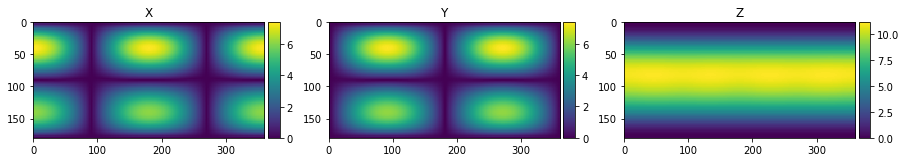

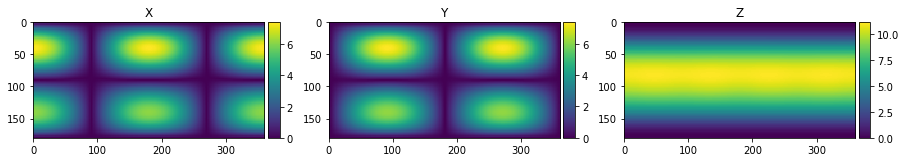

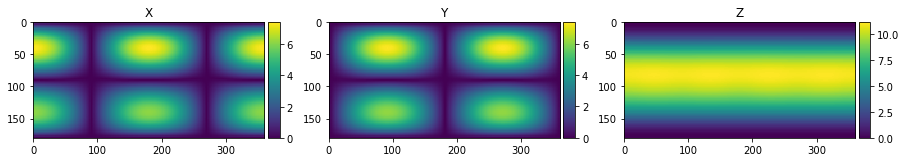

In [5]:
E.plotE(freqndx)
Er.plotE(freqndx)
Ef.plotE(freqndx)

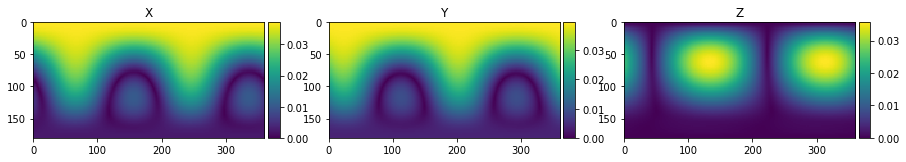

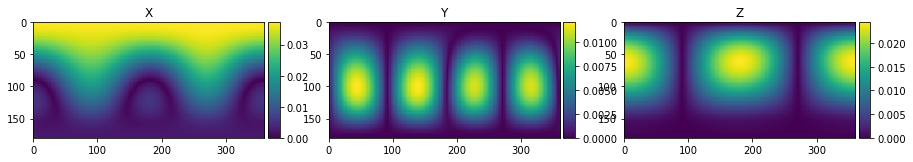

In [6]:
E.plotE(freqndx,Er.E-E.E)
E.plotE(freqndx,Ef.E-E.E)


## Reconstruct a single monopole output

In Kaja's notation, in phase and out of phase means 180 deg rotation. So adding and differencing them should result in invidiual atenna's E-field responses. I rotate -y antenna by 180 degrees to get two patterns that should be the same (by symmetry)

In [7]:
E1 = E.copy(E=(E.E+Eo.E)/2)
E2 = E.copy(E=(E.E-Eo.E)/2).rotate(180)

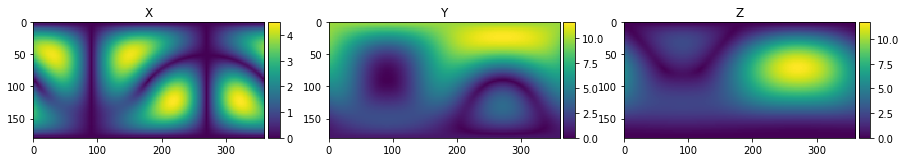

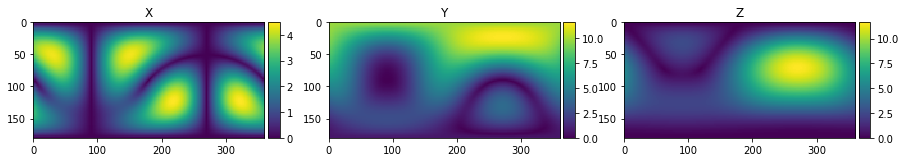

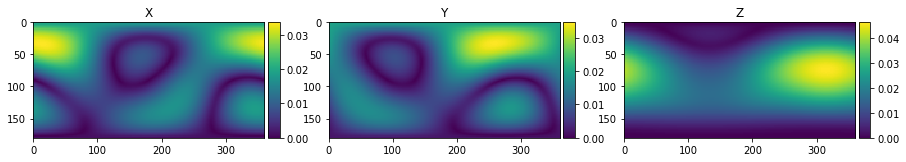

In [8]:
E1.plotE(freqndx)
E2.plotE(freqndx)
E.plotE(freqndx,E1.E-E2.E)

# What about perpendicular configuration?

Now that I have a solution for a single antenna, I can predict what perp configuration should look like

In [9]:
Eperpsim = E.copy(E=E1.E+E1.rotate(-90).E)

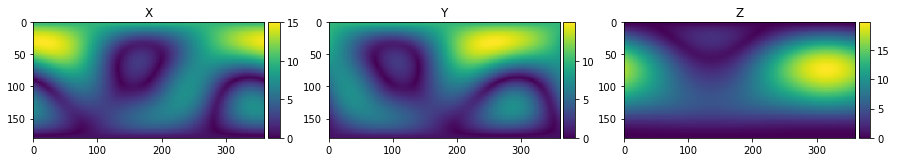

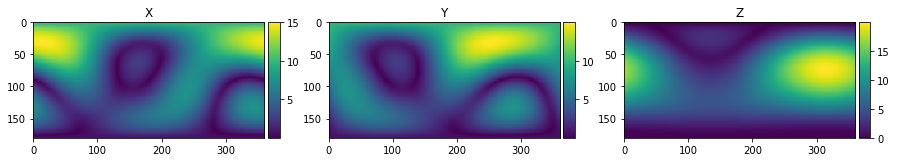

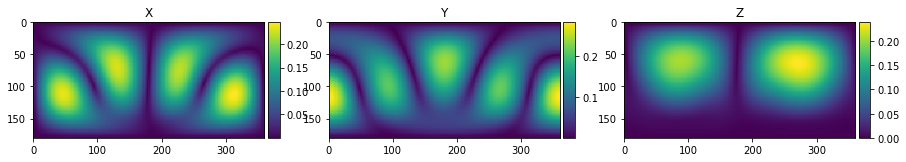

In [10]:
Eperp.plotE(freqndx)
Eperpsim.plotE(freqndx)
E.plotE(freqndx,Eperp.E-Eperpsim.E)

# Let's look at some eigenvalues across frequency

In [11]:
# get power and flatten in theta, phi directions
powr = E.power().reshape((E.Nfreq,-1))
# cov matrix
cov = np.cov(powr)
# eigenvalue decomposition
eva,eve = la.eig(cov)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(4.959748563395942e-07+0j)


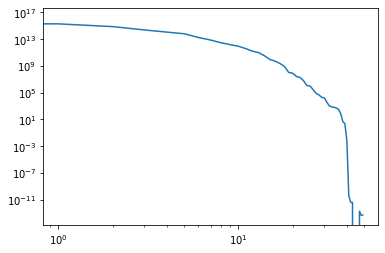

In [12]:
#eigenvalues
plt.plot(eva)
plt.loglog()
print(eva[15]/eva[0])

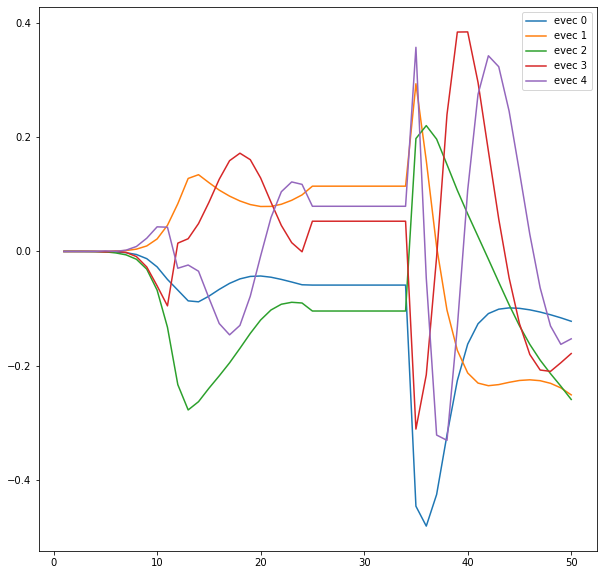

In [13]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.plot(E.freq,np.real(eve[:,i]), label=f'evec {i}')
plt.legend()

Something weird is going on 22-32. Indeed those files are the same:
```
anze@kosovel: ~/work/lusee/AntennaSimResults/002_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/ElectricField [16154] ❱❱ diff ElectricFieldPlot_Freq30MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_in_phase.csv ElectricFieldPlot_Freq31MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_in_phase.csv
anze@kosovel: ~/work/lusee/AntennaSimResults/002_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/ElectricField [16154] ❱❱
```
